In [ ]:
from src.preprocessing.feature_loader import FeatureLoader

feature_loader = FeatureLoader(file_name="feature_extracted")
file_path = feature_loader.data_dir / "feature_extracted.csv"
metadata = feature_loader.load_metadata_file(file_path)
print(metadata.shape)

(1125881, 7)


In [2]:
train_meta, train_emb = feature_loader.transform(split_name="train")
print(train_meta.shape, train_emb.shape)

(788680, 7) (788680, 768)


In [3]:
train_meta = train_meta.reset_index(drop=True)
sampled_train_meta = feature_loader.sample_fraction(metadata=train_meta, fraction=0.05)
sampled_train_emb = train_emb[sampled_train_meta.index]
print(sampled_train_meta.shape, sampled_train_emb.shape)

(39434, 7) (39434, 768)


In [4]:
from umap import UMAP

umap_model = UMAP(
    n_components=2,      # 2 dla wizualizacji, 10–20 dla dalszego klastrowania
    n_neighbors=30,      # większe = gładsza struktura
    min_dist=0.2,
    metric="cosine",  # po L2 odpowiada cosinusowi
    random_state=37,
)

X_umap_2d2 = umap_model.fit_transform(sampled_train_emb)

/Users/mikolajkarapka/Projects/audio-deepfake-detection-uwr/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [6]:
umap_model = UMAP(
    n_components=20,      # 2 dla wizualizacji, 10–20 dla dalszego klastrowania
    n_neighbors=30,      # większe = gładsza struktura
    min_dist=0.1,
    metric="cosine",  # po L2 odpowiada cosinusowi
    random_state=42,
)

X_umap_20d = umap_model.fit_transform(sampled_train_emb)

/Users/mikolajkarapka/Projects/audio-deepfake-detection-uwr/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_umap_clusters(X_umap_2d, clusters, alpha=0.7, cmap='tab20', size=1):
    print(np.sum(clusters == -1))  # Number of noise points
    print(np.unique(clusters, return_counts=True))
    plt.figure(figsize=(10, 8))
    plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], s=size, alpha=alpha, c=clusters, cmap=cmap)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("UMAP embeddings")
    plt.colorbar(label='Cluster Label')
    plt.legend()
    plt.show()

14934
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), array([14934,   380,   364,  1239,   957,   343,   576,   368,   335,
         448,   612,  2323,   615,  1086,   361,  1208,  1410,   964,
         797,   490,  1659,   336,   548,  2718,  1143,   782,   502,
        1041,   895]))


/var/folders/1d/mv_j9c7964b105nch0pj7kgh0000gn/T/ipykernel_53023/430252003.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


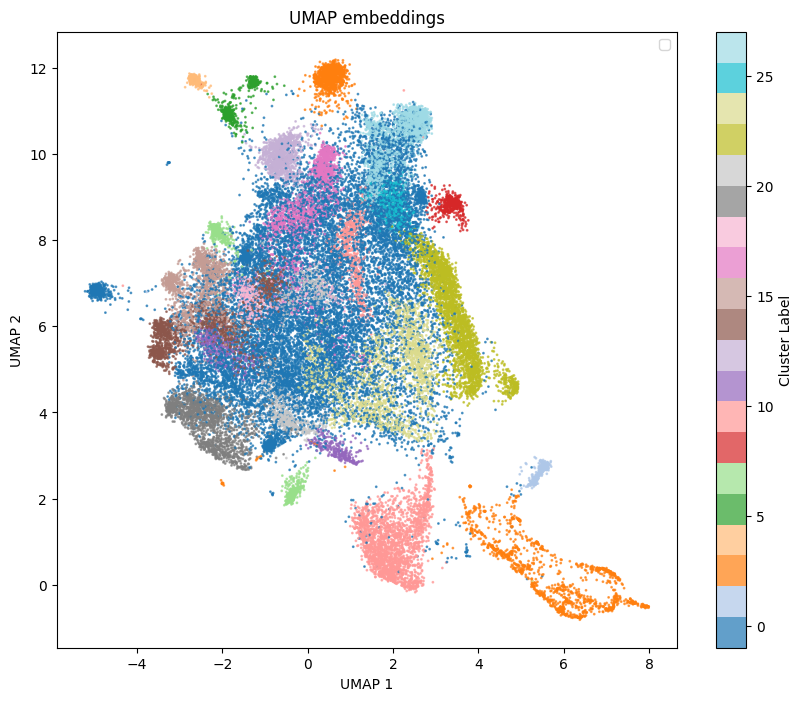

In [20]:
from hdbscan import HDBSCAN

hdbscan_clf = HDBSCAN(
    min_cluster_size=335,
    min_samples=2,
    metric="euclidean",
    cluster_selection_method="eom",
)
hdbscan_clf.fit(X_umap_20d)
clusters = hdbscan_clf.labels_



plot_umap_clusters(X_umap_2d2, clusters, alpha=0.7, cmap='tab20', size=1)

14934
(array([-1]), array([14934]))


/var/folders/1d/mv_j9c7964b105nch0pj7kgh0000gn/T/ipykernel_53023/430252003.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


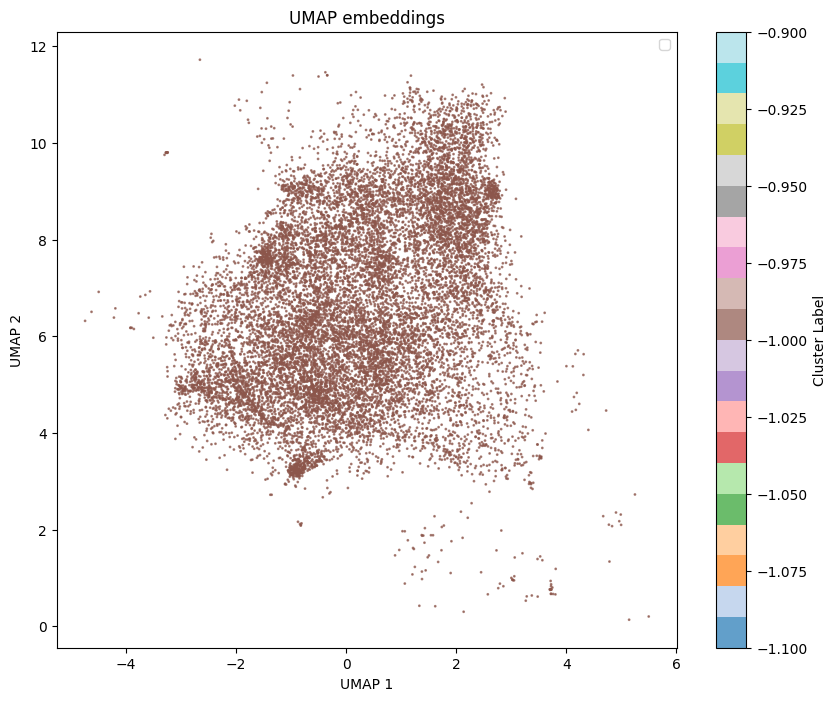

In [10]:
anomaly_indices = np.where(clusters == -1)[0]
plot_umap_clusters(X_umap_2d2[anomaly_indices], clusters[anomaly_indices], alpha=0.7, cmap='tab20', size=1)